# Final Project: Classification
## Margo Wang

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics, tree
from matplotlib import cm
from sklearn import model_selection
import torch
import random
from torch import nn, optim
from IPython import display
from sklearn.metrics import auc, roc_curve
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random
random.seed(15657102)
seed = 15657102
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## Data Preprocessing

In [2]:
df = pd.read_csv('musicData.csv')
df = df.dropna()
df = df.drop(df[df.tempo =='?'].index)
df = df.drop(df[df.duration_ms ==-1].index)
df['tempo'] = pd.to_numeric(df['tempo'])
df = pd.get_dummies(df, columns= ['key','mode'])

In [3]:
test = pd.DataFrame()
for gen in df.music_genre.unique():
    test_temp = df[df['music_genre']==gen].sample(frac = 0.1, random_state=15657102)
    test = pd.concat([test, test_temp])
train = df.drop(index=test.index)
x_train = train[['popularity','acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'key_A', 'key_A#', 'key_B',
       'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F', 'key_F#',
       'key_G', 'key_G#', 'mode_Major', 'mode_Minor']]
x_test = test[['popularity','acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'key_A', 'key_A#', 'key_B',
       'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F', 'key_F#',
       'key_G', 'key_G#', 'mode_Major', 'mode_Minor']]
y_train = pd.get_dummies(train['music_genre'])
y_test = pd.get_dummies(test['music_genre'])

### Normalization

In [4]:
%%capture
x_train[['popularity','acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']] = stats.zscore(x_train[['popularity','acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']])
x_test[['popularity','acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']] = stats.zscore(x_test[['popularity','acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']])

## Dimension Reduction & Clustering

### PCA

In [5]:
pca = PCA(whiten=True)
pca.fit(x_train)
eig_vals = pca.explained_variance_
loadings = pca.components_

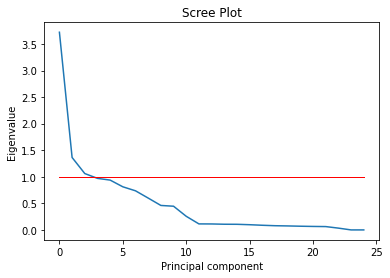

In [6]:
numClasses = 25
plt.plot(eig_vals)
plt.xlabel('Principal component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.plot([0,numClasses-1],[1,1],color='red',linewidth=1);

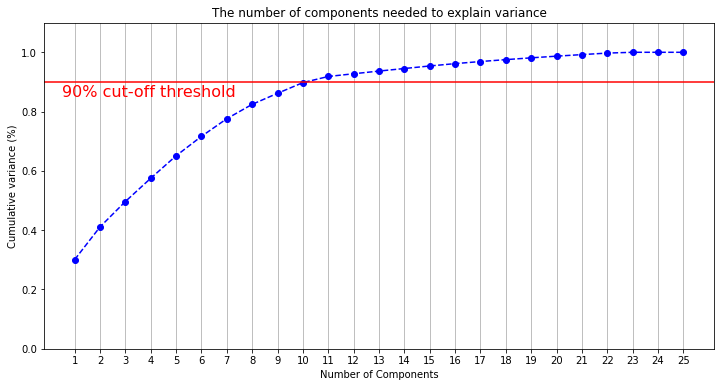

In [12]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 26, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 26, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(0.5, 0.85, '90% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [13]:
x_train_redu = pca.transform(x_train)[:,0:10]
x_test_redu = pca.transform(x_test)[:,0:10]

### K-means Cluserting

#### In 3D

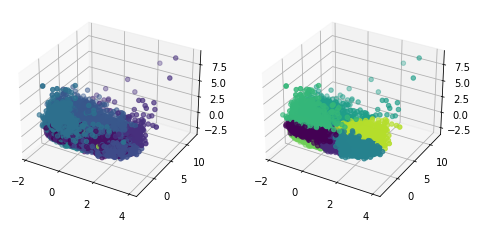

In [10]:
train_color =[]
for i in range(len(y_train)):
    train_color = np.append(train_color, np.argmax(x_train.to_numpy()[i], axis = -1))
pc3 = pca.transform(x_train)[:,0:3]
kMeans = KMeans(n_clusters = 10).fit(pc3)
cId = kMeans.labels_ # vector of cluster IDs that the row belongs to
cCoords = kMeans.cluster_centers_
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d').scatter(pca.transform(x_train)[:,0],pca.transform(x_train)[:,1],pca.transform(x_train)[:,2], c = train_color)
ax = fig.add_subplot(1, 2, 2, projection='3d').scatter(pca.transform(x_train)[:,0],pca.transform(x_train)[:,1],pca.transform(x_train)[:,2], c = cId)
plt.show()

#### In 2D

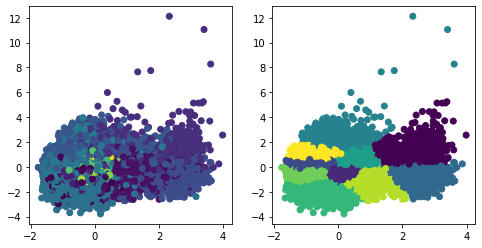

In [11]:
pc2 = pca.transform(x_train)[:,0:2]
kMeans = KMeans(n_clusters = 10).fit(pc2)
cId = kMeans.labels_ # vector of cluster IDs that the row belongs to
cCoords = kMeans.cluster_centers_
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1).scatter(pca.transform(x_train)[:,0],pca.transform(x_train)[:,1], c = train_color)
ax = fig.add_subplot(1, 2, 2).scatter(pca.transform(x_train)[:,0],pca.transform(x_train)[:,1], c = cId)
plt.show()


## Training Model

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X = torch.from_numpy(x_train_redu).type(torch.FloatTensor).to(device)
y = torch.tensor(y_train.values).type(torch.FloatTensor).to(device)

In [23]:

learning_rate = 2e-3
lambda_l2 = 1e-5

D = 10  # dimensions
C = 10  # num_classes
H = 60  # num_hidden_units

criterion = torch.nn.CrossEntropyLoss()
nn_model = nn.Sequential(
    nn.Linear(D,H),
    nn.ReLU(),
    nn.Linear(H,H),
    nn.ReLU(),
    nn.Linear(H,C),
)
nn_model.to(device)


Sequential(
  (0): Linear(in_features=10, out_features=60, bias=True)
  (1): ReLU()
  (2): Linear(in_features=60, out_features=60, bias=True)
  (3): ReLU()
  (4): Linear(in_features=60, out_features=10, bias=True)
)

In [24]:
loss_train=[]
optimizer = torch.optim.Adam(nn_model.parameters(), lr =learning_rate)
for t in range(3000):
    y_pred = nn_model(X)
    loss = criterion(y_pred, y.resize(len(y),10))
    print(f"[Model]:Nerual Network ,[EPOCH]: %i, [LOSS]: %.6f" % (t, loss.item()))
    display.clear_output(wait=True)
    loss_train.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

[Model]:Nerual Network ,[EPOCH]: 2999, [LOSS]: 0.937209


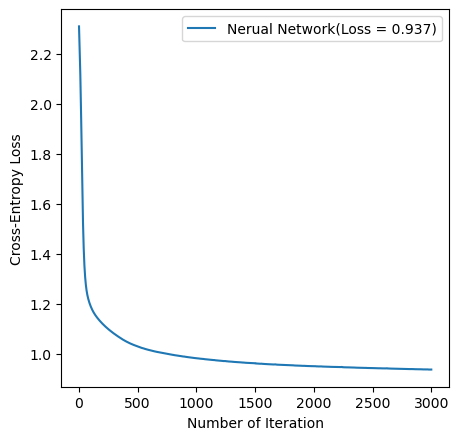

In [25]:
with torch.no_grad():
    plt.figure(figsize=(5, 5), dpi=100)
    plt.plot(loss_train, linestyle='-',label='Nerual Network(Loss = %0.3f)' % loss_train[len(loss_train)-1])
    plt.xlabel('Number of Iteration')
    plt.ylabel('Cross-Entropy Loss')

    plt.legend();

## Evaluation

In [27]:
x_test_nn = torch.from_numpy(x_test_redu).type(torch.FloatTensor).to(device)
y_test_nn =y_test
softmax = nn.Softmax(dim=1)
pred = softmax(nn_model(x_test_nn)).detach().numpy()
AUC_macro = metrics.roc_auc_score(y_test_nn, pred,multi_class='ovr', average = 'macro')
AUC_micro = metrics.roc_auc_score(y_test_nn, pred,multi_class='ovr', average = 'micro')
print('The Area Under the ROC Cruve (macro) of Nerual Network classifer is:',AUC_macro)
print('The Area Under the ROC Cruve (micro) of Nerual Network classifer is:',AUC_micro)

The Area Under the ROC Cruve (macro) of Nerual Network classifer is: 0.9253555296351591
The Area Under the ROC Cruve (micro) of Nerual Network classifer is: 0.9326472044240592


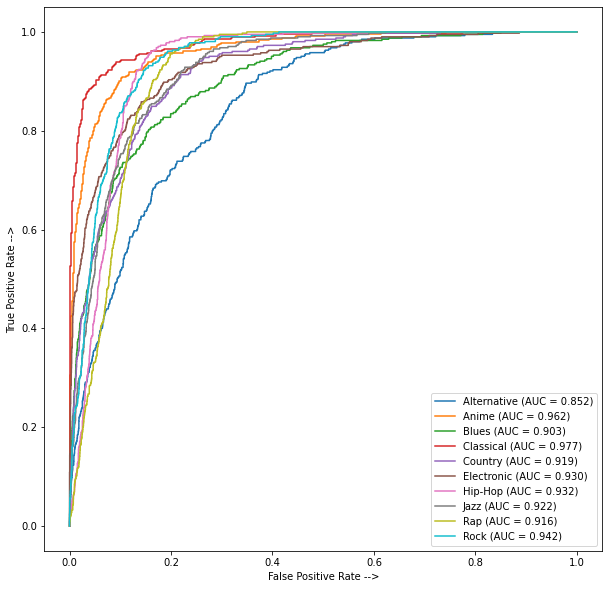

In [28]:
genre = pd.unique(y_test.columns)
temp_df = pd.DataFrame()
plt.figure(figsize=(10,10))
for i in range(len(genre)):
    g = genre[i]
    temp_df['proba'] = pred[:,i]
    temp_df['y'] = np.array(y_test[g])
    temp_df =temp_df.reset_index(drop=True)
    fpr, tpr, threshold = roc_curve(temp_df['y'],temp_df['proba'])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle='-', label= '%s (AUC = %0.3f)' % (g,auc_score))
    plt.xlabel('False Positive Rate -->')
    plt.ylabel('True Positive Rate -->')


plt.legend()
plt.show()


In [29]:
y_true =[]
for i in range(len(y_test)):
    y_true = np.append(y_true, np.argmax(y_test.to_numpy()[i], axis = -1))
acc = sum(y_true == torch.max(nn_model(x_test_nn),1)[1].detach().numpy())/len(y_true)*100
print("The overall accuracy of classification is %3.2f" % acc,'%')

The overall accuracy of classification is 56.80 %


## Extra credit

For Extra credit, I will examine the loading matrix of the PCA to interpret first three princial conpoment.

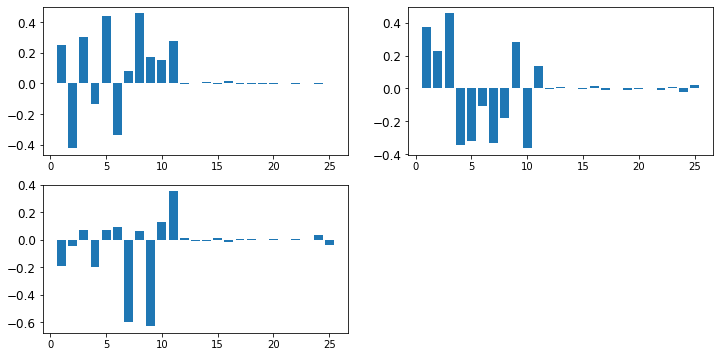

In [51]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(2, 2, 1).bar(np.linspace(1,25,25),-loadings[0,:])
ax = fig.add_subplot(2, 2, 2).bar(np.linspace(1,25,25),-loadings[1,:])
ax = fig.add_subplot(2, 2, 3).bar(np.linspace(1,25,25),-loadings[2,:])
plt.show()